In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats, fft
from datetime import timedelta



In [ ]:
path = r"dataset2-1.csv"
df = pd.read_csv(path)
df.head(4)

,cow,date,hour,IN_ALLEYS,REST,EAT,ACTIVITY_LEVEL,oestrus,calving,lameness,mastitis,LPS,acidosis,other_disease,accidents,disturbance,mixing,management_changes,OK
0,7163,2015-03-02,1,185.517,3414.482,0.0,-755.64814,0,0,0,0,NaN,0,0,0,1,0,0,0
1,7163,2015-03-02,2,0.000,3599.999,0.0,-827.99977,0,0,0,0,NaN,0,0,0,1,0,0,0
2,7163,2015-03-02,3,10.661,3589.338,0.0,-823.84198,0,0,0,0,NaN,0,0,0,1,0,0,0
3,7163,2015-03-02,4,43.800,3556.199,0.0,-810.91777,0,0,0,0,NaN,0,0,0,1,0,0,0


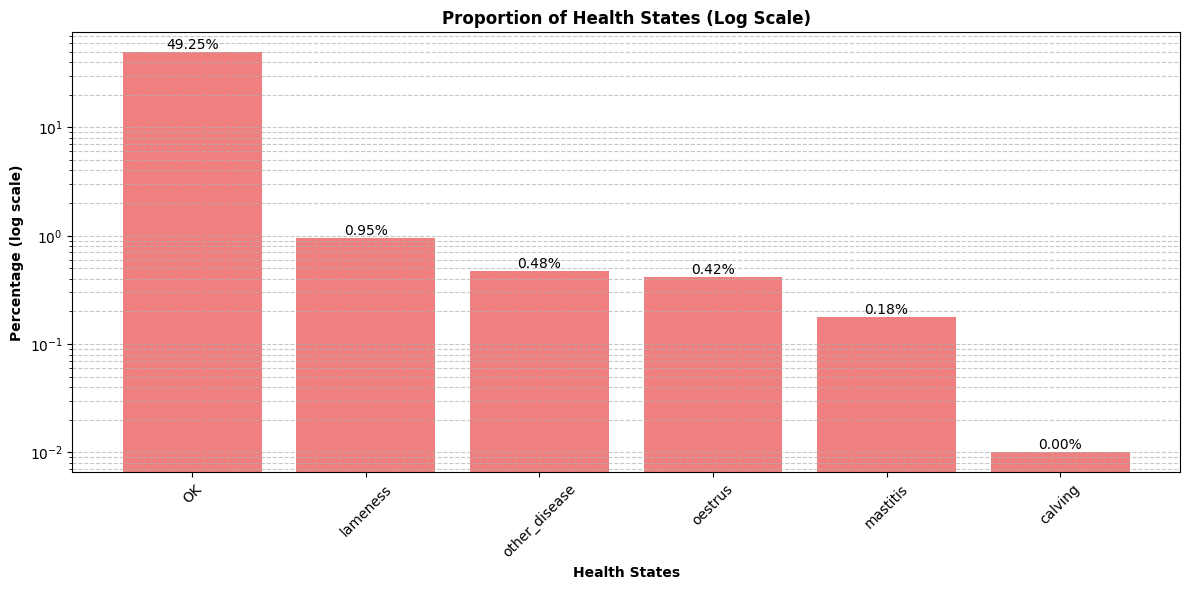

In [ ]:
health_states = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']

df_health = df[health_states]
health_counts = df_health.sum().sort_values(ascending=False)
total = len(df)
health_percent = (health_counts / total) * 100

safe_health_percent = health_percent.copy()
safe_health_percent[safe_health_percent == 0] = 0.01

plt.figure(figsize=(12, 6))
bars = plt.bar(safe_health_percent.index, safe_health_percent.values, color='lightcoral')

for i, bar in enumerate(bars):
    original = health_percent.values[i]
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{original:.2f}%', ha='center', va='bottom')

plt.yscale('log')
plt.title('Proportion of Health States (Log Scale)', fontweight='bold')
plt.xlabel('Health States', fontweight='bold')
plt.ylabel('Percentage (log scale)', fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7, which='both')
plt.tight_layout()
plt.show()

In [ ]:
df['date'] = pd.to_datetime(df['date'])

obs_counts = df.groupby(['cow', 'date']).size().reset_index(name='hour_count')

missing_obs = obs_counts[obs_counts['hour_count'] < 24]

# plt.figure(figsize=(12, 6))
# missing_obs.groupby('cow')['hour_count'].apply(lambda x: (24 - x).sum()).sort_values(ascending=False).plot(kind='bar')
# plt.title("Total Missing Hours per Cow (only cows with missing 24h records)")
# plt.xlabel("Cow ID")
# plt.ylabel("Total Missing Hours")
# plt.tight_layout()
# plt.show()

Investigate the correlation between the "OK" label and other health states.


Check if, in the dataset, when a cow is labeled as OK, there is any other health label equal to 1.


In [ ]:
health_labels = [
    'oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'accidents', 'disturbance',
    'mixing', 'management_changes'
]

correlations = df[health_labels + ['OK']].corr()['OK'].drop('OK')

ok_and_pathology_overlap = df[(df['OK'] == 1) & (df[health_labels].sum(axis=1) > 0)]


print(correlations)
print(ok_and_pathology_overlap)


oestrus              -0.063784
calving                    NaN
lameness             -0.096693
mastitis             -0.041706
other_disease        -0.068208
accidents                  NaN
disturbance          -0.804610
mixing                     NaN
management_changes   -0.010908
Name: OK, dtype: float64
        cow       date  hour  IN_ALLEYS      REST       EAT  ACTIVITY_LEVEL  \
600    7163 2015-03-27     1    114.055  3485.944     0.000      -783.51832   
601    7163 2015-03-27     2     41.395  3558.604     0.000      -811.85572   
602    7163 2015-03-27     3      0.000  3599.999     0.000      -827.99977   
603    7163 2015-03-27     4     52.625  3547.374     0.000      -807.47602   
604    7163 2015-03-27     5     78.736  3521.263     0.000      -797.29273   
...     ...        ...   ...        ...       ...       ...             ...   
38058  2603 2015-03-30    20    405.008  3166.022    28.969      -651.21680   
38059  2603 2015-03-30    21    476.575  1658.526  1337.185     

Manual check

In [ ]:
# Liste des colonnes représentant les états de santé
health_labels = [
    'oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'accidents',
]

# Filtrer les lignes où OK == 1 et au moins un état de santé est aussi à 1
violations = df[(df['OK'] == 1) & (df[health_labels].sum(axis=1) > 0)]

# Vérification et affichage
if violations.empty:
    print("✅ Aucun cas trouvé où OK == 1 et un état de santé est aussi à 1. Tout est cohérent.")
else:
    print("⚠️ Des cas incohérents ont été trouvés ! Voici les lignes concernées :")
    print(violations)


✅ Aucun cas trouvé où OK == 1 et un état de santé est aussi à 1. Tout est cohérent.


## . Data Preprocessing


## . Data Preprocessing


Step 2: Perform another cleaning by keeping only records with more that 18 samples


In [ ]:
df_cleaned =df.copy()
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])

hourly_counts = df_cleaned.groupby(['cow', 'date']).size().reset_index(name='hour_count')


In [ ]:
# Identify 24h records by observation count

records_more_than_18_obs = hourly_counts[hourly_counts['hour_count'] > 18]
records_12_to_18_obs = hourly_counts[(hourly_counts['hour_count'] >= 12) & (hourly_counts['hour_count'] < 18)]
records_less_than_12_obs = hourly_counts[hourly_counts['hour_count'] < 12]

# Merge to filter full rows from original dataframe
df_more_than_18_obs = df_cleaned.merge(records_more_than_18_obs[['cow', 'date']], on=['cow', 'date'])
df_12_to_18_obs = df_cleaned.merge(records_12_to_18_obs[['cow', 'date']], on=['cow', 'date'])
df_less_than_12_obs = df_cleaned.merge(records_less_than_12_obs[['cow', 'date']], on=['cow', 'date'])

# Drop the records with less than 12 observations from the main dataset
df_filtered = df_cleaned[~df_cleaned.set_index(['cow', 'date']).index.isin(df_less_than_12_obs.set_index(['cow', 'date']).index)]

# Print dataset shapes
print("Original dataset shape:", df.shape)
print("After filtering (<12 obs removed):", df_filtered.shape)
print("Deleted rows (<12 obs):", df_less_than_12_obs.shape)
print("Filtered dataset (>18 obs):", df_more_than_18_obs.shape)
print("Filtered dataset (12–18 obs):", df_12_to_18_obs.shape)

Original dataset shape: (40247, 19)
After filtering (<12 obs removed): (40247, 19)
Deleted rows (<12 obs): (0, 19)
Filtered dataset (>18 obs): (40247, 19)
Filtered dataset (12–18 obs): (0, 19)


In [ ]:
# Save datasets
df_more_than_18_obs.to_csv(r"filtered_dataset_more_than_18_obs.csv", index=False)

In [ ]:
# Count number of unique (cow, date) pairs and unique cows for df_more_than_18_days
num_days_more_than_18 = df_more_than_18_obs[['cow', 'date']].drop_duplicates().shape[0]
num_cows_more_than_18 = df_more_than_18_obs['cow'].nunique()

# Count number of unique (cow, date) pairs and unique cows for df_12_to_18_days
num_days_12_to_18 = df_12_to_18_obs[['cow', 'date']].drop_duplicates().shape[0]
num_cows_12_to_18 = df_12_to_18_obs['cow'].nunique()

# Print results
print("More than 18 days:")
print(f"Number of unique days: {num_days_more_than_18}")
print(f"Number of unique cows: {num_cows_more_than_18}")

print("\n12 to 18 days:")
print(f"Number of unique days: {num_days_12_to_18}")
print(f"Number of unique cows: {num_cows_12_to_18}")


More than 18 days:
Number of unique days: 1677
Number of unique cows: 28

12 to 18 days:
Number of unique days: 0
Number of unique cows: 0


Total gaps found: 2


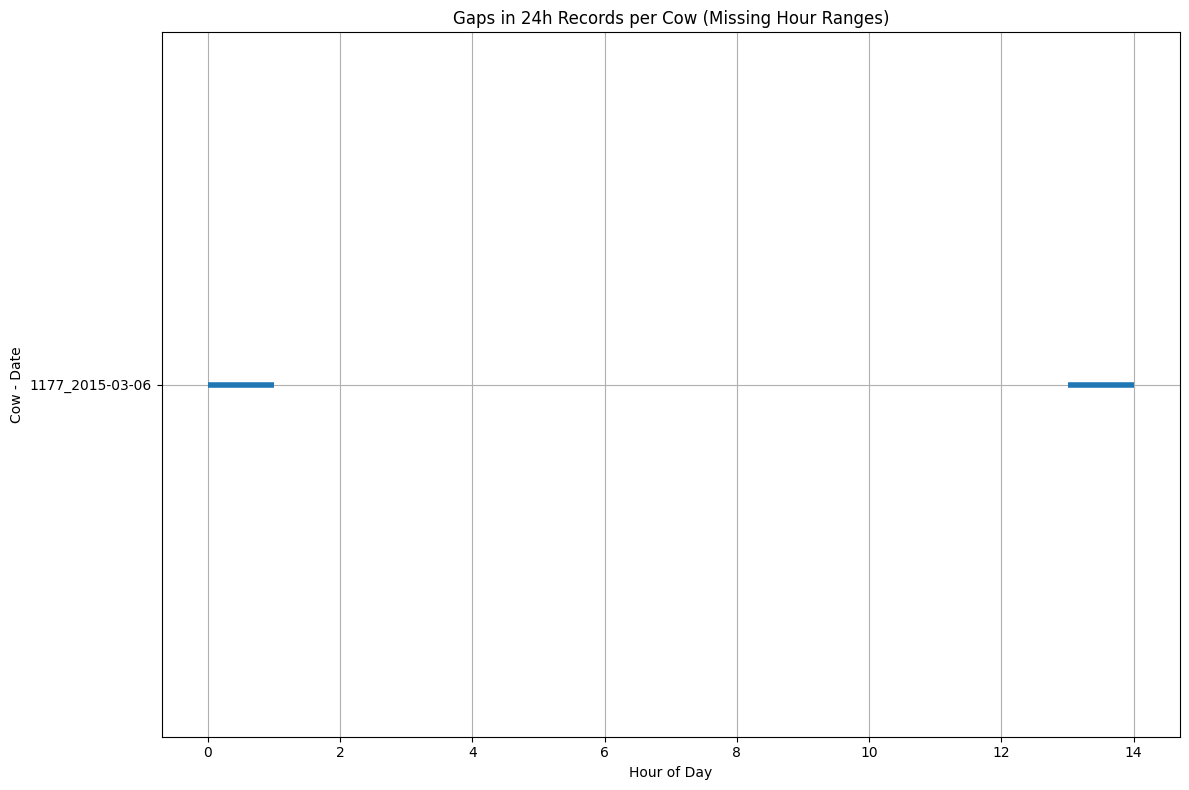

In [ ]:
df = pd.read_csv(r"filtered_dataset_more_than_18_obs.csv")


# Ensure correct types
df['hour'] = df['hour'].astype(int)
df['date'] = pd.to_datetime(df['date'])

# Identify full range of hours
full_hours = list(range(24))

# Keep only cows that have missing hours
hour_counts = df.groupby(['cow', 'date'])['hour'].nunique().reset_index(name='hour_count')
incomplete_days = hour_counts[hour_counts['hour_count'] < 24]
df_incomplete = df.merge(incomplete_days[['cow', 'date']], on=['cow', 'date'])

# Build gap data
gap_data = []
for (cow, date), group in df_incomplete.groupby(['cow', 'date']):
    observed_hours = sorted(group['hour'].unique())
    missing_hours = sorted(set(full_hours) - set(observed_hours))
    gaps = []
    if missing_hours:
        start = missing_hours[0]
        for i in range(1, len(missing_hours)):
            if missing_hours[i] != missing_hours[i-1] + 1:
                gaps.append((start, missing_hours[i-1]))
                start = missing_hours[i]
        gaps.append((start, missing_hours[-1]))
        for g_start, g_end in gaps:
            gap_data.append({
                'cow': cow,
                'date': date,
                'start_hour': g_start,
                'end_hour': g_end
            })

gap_df = pd.DataFrame(gap_data)

# Plot gaps
print(f"Total gaps found: {len(gap_df)}")
if len(gap_df):
    plt.figure(figsize=(12, 8))
    for cow in gap_df['cow'].unique():
        cow_data = gap_df[gap_df['cow'] == cow]
        for i, row in cow_data.iterrows():
            plt.hlines(y=f"{row['cow']}_{row['date'].date()}", xmin=row['start_hour'], xmax=row['end_hour']+1, linewidth=4)

    plt.xlabel('Hour of Day')
    plt.ylabel('Cow - Date')
    plt.title('Gaps in 24h Records per Cow (Missing Hour Ranges)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
df.head(24)

,cow,date,hour,IN_ALLEYS,REST,EAT,ACTIVITY_LEVEL,oestrus,calving,lameness,mastitis,LPS,acidosis,other_disease,accidents,disturbance,mixing,management_changes,OK
0,7163,2015-03-02,1,185.517,3414.482,0.000,-755.64814,0,0,0,0,NaN,0,0,0,1,0,0,0
1,7163,2015-03-02,2,0.000,3599.999,0.000,-827.99977,0,0,0,0,NaN,0,0,0,1,0,0,0
2,7163,2015-03-02,3,10.661,3589.338,0.000,-823.84198,0,0,0,0,NaN,0,0,0,1,0,0,0
3,7163,2015-03-02,4,43.800,3556.199,0.000,-810.91777,0,0,0,0,NaN,0,0,0,1,0,0,0
4,7163,2015-03-02,5,17.167,3582.832,0.000,-821.30464,0,0,0,0,NaN,0,0,0,1,0,0,0
5,7163,2015-03-02,6,1313.335,509.689,1776.975,839.23463,0,0,0,0,NaN,0,0,0,1,0,0,0
6,7163,2015-03-02,7,153.857,0.000,3446.142,1471.99676,0,0,0,0,NaN,0,0,0,1,0,0,0
7,7163,2015-03-02,8,450.335,365.718,2780.390,1155.70226,0,0,0,0,NaN,0,0,0,1,0,0,0
8,7163,2015-03-02,9,2627.864,195.151,776.984,701.90679,0,0,0,0,NaN,0,0,0,1,0,0,0
9,7163,2015-03-02,10,1222.628,273.509,2099.134,1014.34969,0,0,0,0,NaN,0,0,0,1,0,0,0


Step 1: Perform initial cleaning by keeping only physiological classes:


Retain: mastitis, lameness, oestrus, calving, other_diseases, OK.


Remove: management changes, mixing, disturbance, accidents, LPS, acidosis.

In [ ]:
# houni khedmet lamya o roua mtaa el KNN imputation
df = pd.read_csv(r"filtered_dataset_more_than_18_obs.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Convert the 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Sort the data by cow and date
df = df.sort_values(by=['cow', 'date'])

# Function to get durations for a specific health state
def get_health_state_durations(df, health_state_column):
    durations = []

    # For each cow
    for cow_id, group in df.groupby('cow'):
        group = group.sort_values('date').reset_index(drop=True)

        current_state = False
        start_date = None
        prev_date = None

        for i, row in group.iterrows():
            if row[health_state_column] == 1:
                if not current_state:
                    # Start new period
                    current_state = True
                    start_date = row['date']
                elif prev_date is not None and (row['date'] - prev_date).days > 1:
                    # Gap detected → close previous period
                    end_date = prev_date
                    duration = (end_date - start_date).days + 1
                    durations.append({
                        'cow': cow_id,
                        'health_state': health_state_column,
                        'start_date': start_date,
                        'end_date': end_date,
                        'duration_days': duration
                    })
                    # Start new period
                    start_date = row['date']
            else:
                if current_state:
                    end_date = prev_date if prev_date is not None else row['date']
                    duration = (end_date - start_date).days + 1
                    durations.append({
                        'cow': cow_id,
                        'health_state': health_state_column,
                        'start_date': start_date,
                        'end_date': end_date,
                        'duration_days': duration
                    })
                    current_state = False
                    start_date = None

            prev_date = row['date']

        # Handle case where last rows are 1s
        if current_state:
            end_date = prev_date
            duration = (end_date - start_date).days + 1
            durations.append({
                'cow': cow_id,
                'health_state': health_state_column,
                'start_date': start_date,
                'end_date': end_date,
                'duration_days': duration
            })

    return pd.DataFrame(durations)

# Dictionaries to store durations
state_durations = {}
durations_min_max = {}

# Compute durations for each health state
for state in health_states:
    durations_df = get_health_state_durations(df, state)
    state_durations[state] = durations_df

    if not durations_df.empty:
        min_duration = durations_df['duration_days'].min()
        max_duration = durations_df['duration_days'].max()
        durations_min_max[state] = {'min_days': min_duration, 'max_days': max_duration}
    else:
        durations_min_max[state] = {'min_days': None, 'max_days': None}

# Display results
for state, durations in durations_min_max.items():
    min_days = durations['min_days']
    max_days = durations['max_days']

    if min_days is None or max_days is None:
        print(f"No data available for \"{state}\".")
    elif min_days == max_days:
        print(f"{state.capitalize()} lasts {min_days} day{'s' if min_days > 1 else ''}.")
    else:
        print(f"{state.capitalize()} lasts between {min_days} and {max_days} days.")

Oestrus lasts between 1 and 2 days.
No data available for "calving".
Lameness lasts 1 day.
Mastitis lasts 1 day.
Other_disease lasts 1 day.
Ok lasts between 1 and 6 days.


nbadlou el code bel bagra ywali ykharej tableau felekher kol bargra kadech yokaed kol event when happened

In [ ]:

# Step 1: Identify event columns dynamically
non_event_cols = ['cow', 'date', 'hour', 'IN_ALLEYS','REST','EAT','ACTIVITY_LEVEL', 'OK']
event_cols = [col for col in df.columns if col not in non_event_cols]

# Step 2: Aggregate daily events
daily = df.groupby(['cow', 'date'])[event_cols].max().reset_index()
daily['date'] = pd.to_datetime(daily['date'])

# Step 3: Create full cow x day table
all_dates = pd.date_range(daily['date'].min() - timedelta(days=7), daily['date'].max() + timedelta(days=7))
cows = daily['cow'].unique()
full_daily = pd.MultiIndex.from_product([cows, all_dates], names=['cow', 'date']).to_frame(index=False)

# Merge and fill missing
full_daily = full_daily.merge(daily, on=['cow', 'date'], how='left')
full_daily[event_cols] = full_daily[event_cols].fillna(0)

# Add LABEL and default OK
full_daily['LABEL'] = 'control'
full_daily['OK'] = 1

# Step 4: Spread rules
spread_rules = {
    'oestrus': {'before': 1, 'after': 1},
    'calving': {'before': 2, 'after': 1},
    'lameness': {'before': 2, 'after': 1},
    'mastitis': {'before': 2, 'after': 1},
    'acidosis': {'before': 2, 'after': 1},
    'LPS': {'before': 2, 'after': 1},
    'other_disease': {'before': 2, 'after': 1},
    'accidents': {'before': 2, 'after': 1},
    'disturbance': {'before': 0, 'after': 0},
    'mixing': {'before': 0, 'after': 0},
    'management_changes': {'before': 0, 'after': 0},
}

for cond in event_cols:
    if cond not in spread_rules:
        continue
    sub = full_daily[full_daily[cond] == 1][['cow', 'date']].sort_values(['cow', 'date'])
    for cow_id in sub['cow'].unique():
        cow_days = sub[sub['cow'] == cow_id]['date'].sort_values()
        episode = []
        prev_day = None
        for day in cow_days:
            if prev_day is None or (day - prev_day).days > 1:
                if episode:
                    min_day = min(episode)
                    max_day = max(episode)
                    spread = spread_rules[cond]
                    spread_days = pd.date_range(min_day - timedelta(days=spread['before']), max_day + timedelta(days=spread['after']))
                    mask = (full_daily['cow'] == cow_id) & (full_daily['date'].isin(spread_days))
                    full_daily.loc[mask, cond] = 1
                    full_daily.loc[mask & (full_daily['LABEL'] == 'control'), 'LABEL'] = cond
                    full_daily.loc[mask, 'OK'] = 0
                episode = [day]
            else:
                episode.append(day)
            prev_day = day
        if episode:
            min_day = min(episode)
            max_day = max(episode)
            spread = spread_rules[cond]
            spread_days = pd.date_range(min_day - timedelta(days=spread['before']), max_day + timedelta(days=spread['after']))
            mask = (full_daily['cow'] == cow_id) & (full_daily['date'].isin(spread_days))
            full_daily.loc[mask, cond] = 1
            full_daily.loc[mask & (full_daily['LABEL'] == 'control'), 'LABEL'] = cond
            full_daily.loc[mask, 'OK'] = 0

# Step 5: Prepare df before merging (drop event columns to avoid conflict)
df['date'] = pd.to_datetime(df['date'])
df = df.drop(columns=event_cols + ['OK'], errors='ignore')  # <<< DROP these before merging

# Merge cleanly
final = df.merge(full_daily[['cow', 'date', 'LABEL'] + event_cols + ['OK']], on=['cow', 'date'], how='left')

# Step 6: If a day was labeled with an event, update hourly events if missing
for cond in event_cols:
    final.loc[(final['LABEL'] == cond) & (final[cond] == 0), cond] = 1

final.to_csv(r"labelled&aligned_dataset.csv", index=False)

final.head(24)

,cow,date,hour,IN_ALLEYS,REST,EAT,ACTIVITY_LEVEL,LABEL,oestrus,calving,lameness,mastitis,LPS,acidosis,other_disease,accidents,disturbance,mixing,management_changes,OK
0,151,2015-03-02,1,461.007,3126.318,10.470,-640.89462,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
1,151,2015-03-02,2,27.001,3572.998,0.000,-817.46938,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
2,151,2015-03-02,3,12.114,3580.726,0.000,-821.62874,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
3,151,2015-03-02,4,795.072,2525.189,276.984,-337.24867,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
4,151,2015-03-02,5,476.794,2966.835,148.657,-543.64907,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
5,151,2015-03-02,6,1667.691,460.360,1471.948,779.16592,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
6,151,2015-03-02,7,197.465,0.000,3402.534,1460.65868,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
7,151,2015-03-02,8,643.792,611.568,2344.639,947.09446,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
8,151,2015-03-02,9,153.095,3137.279,309.625,-567.03647,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
9,151,2015-03-02,10,461.982,0.000,3138.017,1391.88426,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0


In [ ]:
# Step 5: Visual check of consecutive days labeling

# Choose a cow to inspect
#cow_to_check = final['cow'].sample(1).iloc[0]  # or manually set, e.g., cow_to_check = 10127
cow_to_check = 156
# Filter that cow
cow_data = final[final['cow'] == cow_to_check][['cow', 'date', 'hour', 'LABEL']]

# Group by date (daily view)
daily_view = cow_data.groupby(['cow', 'date'])['LABEL'].agg(lambda x: x.mode()[0]).reset_index()

# Display consecutive days
print(f"Consecutive days labeling for Cow {cow_to_check}:")
display(daily_view.sort_values('date'))

Consecutive days labeling for Cow 156:


,cow,date,LABEL
0,156,2015-03-02,acidosis
1,156,2015-03-03,acidosis
2,156,2015-03-04,disturbance
3,156,2015-03-05,control
4,156,2015-03-06,control
5,156,2015-03-07,control
6,156,2015-03-08,control
7,156,2015-03-09,oestrus
8,156,2015-03-10,oestrus
9,156,2015-03-11,oestrus


**Investigating before imputation**

In [ ]:
import pandas as pd

# Step 0: Load the dataset
file_path = r"labelled&aligned_dataset.csv"
df = pd.read_csv(file_path)

# Step 1: Define useful and unwanted classes
useful_classes = ['mastitis', 'lameness', 'oestrus', 'calving', 'other_disease', 'OK']
removed_classes = ['management_changes', 'mixing', 'disturbance', 'accidents', 'LPS', 'acidosis']

# Step 2: Tag samples based on unwanted classes
df['had_removed_class'] = df[removed_classes].max(axis=1)  # 1 if any unwanted class was active

# Step 3: After dropping unwanted classes, check if any useful class remains
df['has_useful_class'] = df[useful_classes].max(axis=1)  # 1 if any useful class active

# Step 4: Identify rows needing reassignment
rows_to_reassign = df[(df['had_removed_class'] == 1) & (df['has_useful_class'] == 0)]

# Step 5: Summary statistics
total_rows = len(df)
total_to_reassign = len(rows_to_reassign)
proportion = total_to_reassign / total_rows * 100

print(f"Total rows in dataset: {total_rows}")
print(f"Rows needing reassignment: {total_to_reassign}")
print(f"Proportion needing reassignment: {proportion:.2f}%")


Total rows in dataset: 40247
Rows needing reassignment: 22896
Proportion needing reassignment: 56.89%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Step 2: Detect samples related to removed classes
df['needs_replacement'] = df[removed_classes].max(axis=1)  # 1 if any removed class is active

# Step 3: Create the physiological label
# Priority: if multiple physiological labels active, pick the first in useful_classes
def get_physio_label(row):
    for cond in useful_classes:
        if row[cond] == 1:
            return cond
    return None

df['physio_label'] = df.apply(get_physio_label, axis=1)

# Step 4: Split into clean vs. to-replace
to_replace = df[(df['needs_replacement'] == 1) & (df['physio_label'].isnull())].copy()
clean_physio = df[(df['needs_replacement'] == 0) & (df['physio_label'].notnull())].copy()

In [ ]:
behavior_features = ['IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL']

# Only disease cases for training
disease_classes = ['mastitis', 'lameness', 'oestrus', 'calving', 'other_disease']

train_disease = clean_physio[clean_physio['physio_label'].isin(disease_classes)]

X_train = train_disease[behavior_features]
y_train = train_disease['physio_label']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# with KNN

In [ ]:

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Step 6: Predict missing labels
X_missing = scaler.transform(to_replace[behavior_features])
predicted_labels = knn.predict(X_missing)

# Assign the new labels
to_replace['physio_label'] = predicted_labels

# Step 6.1: Analyze reassignment
reassignment_summary = pd.Series(predicted_labels).value_counts().reset_index()
reassignment_summary.columns = ['Physiological_Class', 'Number_of_Reassigned_Samples']

print(reassignment_summary)

  Physiological_Class  Number_of_Reassigned_Samples
0            lameness                         16570
1             oestrus                          6235
2            mastitis                            91


In [ ]:
# Step 7: Merge back
# For each predicted label, mark the corresponding event column to 1
for cond in useful_classes:
    to_replace.loc[to_replace['physio_label'] == cond, cond] = 1

# Clean removed columns
df_final = pd.concat([clean_physio, to_replace], axis=0)
df_final = df_final.drop(columns=removed_classes + ['needs_replacement'])

# Optional: reorder if needed
df_final = df_final.sort_values(by=['cow', 'date', 'hour']).reset_index(drop=True)


In [ ]:
# Step 8: Save the cleaned and reconstructed dataset
df_final.to_csv('final2_cleaned_and_reassigned_dataset.csv', index=False)

# Show sample
df_final[['cow', 'date', 'hour', 'physio_label']].sample(10)

,cow,date,hour,physio_label
20744,2175,2015-03-03,10,oestrus
10872,1624,2015-04-23,2,lameness
3700,156,2015-04-15,5,lameness
337,151,2015-03-16,2,OK
19136,2165,2015-04-24,10,lameness
793,151,2015-04-04,2,lameness
12893,2155,2015-03-21,7,OK
5316,162,2015-04-22,13,OK
17423,2164,2015-04-06,1,oestrus
28972,2603,2015-03-07,6,lameness


**Imputation using GAN**

In [ ]:
!pip install torch


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 10
feature_dim = X_train_scaled.shape[1]

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, feature_dim)
        )
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.001)
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.001)

# ===== Step 3: Train GAN =====
real_data = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
batch_size = 64
epochs = 1000

for epoch in range(epochs):
    # Train discriminator
    z = torch.randn(real_data.size(0), latent_dim).to(device)
    fake_data = G(z)

    real_labels = torch.ones(real_data.size(0), 1).to(device)
    fake_labels = torch.zeros(real_data.size(0), 1).to(device)

    d_loss_real = criterion(D(real_data), real_labels)
    d_loss_fake = criterion(D(fake_data.detach()), fake_labels)
    d_loss = d_loss_real + d_loss_fake

    D.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # Train generator
    z = torch.randn(real_data.size(0), latent_dim).to(device)
    fake_data = G(z)
    g_loss = criterion(D(fake_data), real_labels)

    G.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# ===== Step 4: Generate synthetic features for missing samples =====
num_missing = len(to_replace)
z = torch.randn(num_missing, latent_dim).to(device)
generated_features = G(z).detach().cpu().numpy()
generated_features = np.clip(generated_features, -3, 3)  # Optionnel

# ===== Step 5: Classify generated samples =====

generated_labels = np.random.choice(disease_classes, size=num_missing)

to_replace[behavior_features] = scaler.inverse_transform(generated_features)
to_replace['physio_label'] = generated_labels

# ===== Step 6: Analyse & merge =====
reassignment_summary = pd.Series(generated_labels).value_counts().reset_index()
reassignment_summary.columns = ['Physiological_Class', 'Number_of_Reassigned_Samples']
print(reassignment_summary)

df_final = pd.concat([clean_physio, to_replace], axis=0)
df_final = df_final.drop(columns=removed_classes + ['needs_replacement'])
df_final = df_final.sort_values(by=['cow', 'date', 'hour']).reset_index(drop=True)


Epoch 0, D Loss: 1.3769, G Loss: 0.6264
Epoch 200, D Loss: 1.2184, G Loss: 0.8394
Epoch 400, D Loss: 1.2132, G Loss: 0.8794
Epoch 600, D Loss: 1.2358, G Loss: 0.9302
Epoch 800, D Loss: 1.3042, G Loss: 0.7692
  Physiological_Class  Number_of_Reassigned_Samples
0            lameness                          4706
1             calving                          4571
2            mastitis                          4552
3             oestrus                          4534
4       other_disease                          4533


In [ ]:
df_final.to_csv(r'GAN_cleaned_and_reassigned_dataset.csv', index=False)
print(df_final[['cow', 'date', 'hour', 'physio_label']].sample(10))

        cow        date  hour   physio_label
10166  1624  2015-03-24    16        oestrus
4038    156  2015-04-29     7       lameness
5762    173  2015-03-12     3       mastitis
32887  8200  2015-03-07     9             OK
9512   1177  2015-04-24    10  other_disease
29345  2603  2015-03-22    19             OK
30828  2622  2015-03-24    14       mastitis
13701  2155  2015-04-26    23             OK
12414  2152  2015-04-30     8       lameness
10833  1624  2015-04-21    11       lameness


# one hour shifting process

In [ ]:
# Parameters
window_size_hours = 24
min_valid_hours = 18
shift_hours = 1
condition_columns = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease']

# Adjust hour 24 to 00 and increment the date
df['adjusted_date'] = df['date']
df['adjusted_hour'] = df['hour']
df.loc[df['hour'] == 24, 'adjusted_date'] = pd.to_datetime(df.loc[df['hour'] == 24, 'date']) + timedelta(days=1)
df.loc[df['hour'] == 24, 'adjusted_hour'] = 0

# Ensure datetime format
df['adjusted_date'] = pd.to_datetime(df['adjusted_date'])

# Combine adjusted_date and adjusted_hour into a timestamp
df['timestamp'] = pd.to_datetime(df['adjusted_date'].dt.strftime('%Y-%m-%d') + ' ' + df['adjusted_hour'].astype(str) + ':00:00')
df = df.sort_values(['cow', 'timestamp'])

# Group by cow
grouped = df.groupby('cow')
shifted_windows = []

for cow_id, group in grouped:
    timestamps = group['timestamp'].tolist()
    group = group.set_index('timestamp')  # Index by timestamp for easy lookup

    print(f"\n🐄 Processing cow {cow_id} with {len(timestamps)} records...")

    for start_time in timestamps:
        end_time = start_time + timedelta(hours=window_size_hours)
        collected_hours = []
        current_time = start_time
        previous_date = current_time.date()

        while current_time < end_time:
            if current_time in group.index:
                current_date = current_time.date()

                # Stop if there's a day gap
                if (current_date - previous_date).days > 1:
                    print(f"🛑 Stopping at {current_time} due to missing day.")
                    break

                collected_hours.append(group.loc[current_time]['ACTIVITY_LEVEL'])
                previous_date = current_date
                current_time += timedelta(hours=1)
            else:
                # Hour is missing, skip it but advance time
                print(f"⚠️  Missing hour at {current_time}, skipping.")
                current_date = current_time.date()

                if (current_date - previous_date).days > 0:
                    print(f"🛑 Stopping at {current_time} due to day gap after missing hour.")
                    break

                previous_date = current_date
                current_time += timedelta(hours=1)

        if len(collected_hours) >= min_valid_hours:
            end_effective = start_time + timedelta(hours=len(collected_hours) - 1)

            # Get condition values across the window
            condition_window = group.loc[start_time:end_effective]
            condition_counts = condition_window[condition_columns].sum()

            # Prepare final label dictionary: all 0s initially
            final_conditions = {col: 0 for col in condition_columns}

            if (condition_counts > 0).any():
                most_frequent_condition = condition_counts.idxmax()
                final_conditions[most_frequent_condition] = 1
                final_conditions['OK'] = 0
            else:
                final_conditions['OK'] = 1


            shifted_windows.append({
                'cow': cow_id,
                'start_time': start_time,
                'end_time': end_effective,
                'duration_hours': len(collected_hours),
                'activity_window': collected_hours,
                **final_conditions
            })

            print(f"✅ Window for cow {cow_id} → {most_frequent_condition if (condition_counts > 0).any() else 'healthy'}")
        else:
            print(f"❌ Discarded window for cow {cow_id} from {start_time}: only {len(collected_hours)} valid hours.")

# Final DataFrame
shifted_df = pd.DataFrame(shifted_windows)

print("\n✅ DONE.")
print(f"Total valid windows collected: {len(shifted_df)}")
display(shifted_df.head())


🐄 Processing cow 151 with 1440 records...
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → heal

,cow,start_time,end_time,duration_hours,activity_window,oestrus,calving,lameness,mastitis,other_disease,OK
0,151,2015-03-02 01:00:00,2015-03-03 00:00:00,24,"[-640.89462, -817.46938, -821.62874, -337.2486...",0,0,0,0,0,1
1,151,2015-03-02 02:00:00,2015-03-03 01:00:00,24,"[-817.46938, -821.62874, -337.24867, -543.6490...",0,0,0,0,0,1
2,151,2015-03-02 03:00:00,2015-03-03 02:00:00,24,"[-821.62874, -337.24867, -543.64907, 779.16592...",0,0,0,0,0,1
3,151,2015-03-02 04:00:00,2015-03-03 03:00:00,24,"[-337.24867, -543.64907, 779.16592, 1460.65868...",0,0,0,0,0,1
4,151,2015-03-02 05:00:00,2015-03-03 04:00:00,24,"[-543.64907, 779.16592, 1460.65868, 947.09446,...",0,0,0,0,0,1


In [ ]:
output_csv_path = "OneHourShift.csv"
shifted_df.to_csv(output_csv_path, index=False)
print(f"CSV file saved to {output_csv_path}")

CSV file saved to OneHourShift.csv


# New dataset with one hour shift and the new 32 features

In [ ]:
# ----------------------------
# 1. Feature Calculation Logic
# ----------------------------

def calculate_all_features(activity_windows):
    features = []

    for window in activity_windows:
        try:
            window = np.array(window)
            feature_dict = {}

            # Time-Domain Features (1–17)
            feature_dict['Minimum'] = np.min(window)
            feature_dict['Maximum'] = np.max(window)
            feature_dict['Mean'] = np.mean(window)
            feature_dict['RMS'] = np.sqrt(np.mean(np.square(window)))
            feature_dict['STD'] = np.std(window)

            # 6-hour windows
            six_h_windows = [window[i*6:(i+1)*6] for i in range(4)]
            stds_6h = [np.std(w) for w in six_h_windows]
            means_6h = [np.mean(w) for w in six_h_windows]
            feature_dict['MeanSTD6h'] = np.mean(stds_6h)
            feature_dict['STDMean6h'] = np.std(means_6h)

            diffs = np.diff(window)
            feature_dict['STDSD'] = np.std(diffs)


            # RMSSD (successive differences)
            feature_dict['RMSSD'] = np.sqrt(np.mean(np.square(diffs)))

            # Distribution features
            feature_dict['Mode'] = stats.mode(window, keepdims=True)[0][0] if len(window) > 0 else np.nan
            feature_dict['Q10'] = np.percentile(window, 10)
            feature_dict['Q90'] = np.percentile(window, 90)
            feature_dict['Q25'] = np.percentile(window, 25)
            feature_dict['Q50'] = np.percentile(window, 50)
            feature_dict['Q75'] = np.percentile(window, 75)
            feature_dict['Skewness'] = stats.skew(window)
            feature_dict['Kurtosis'] = stats.kurtosis(window)

            # Autocorrelation (lags 1 to 11)
            for lag in range(1, 12):
                if len(window) > lag:
                    corr = np.corrcoef(window[:-lag], window[lag:])[0, 1]
                else:
                    corr = np.nan
                feature_dict[f'Autocorr{lag}'] = corr

            # Frequency-Domain Features (harmonics)
            fft_result = np.abs(fft.fft(window))
            harmonics = fft_result[1:5]
            for i, h in enumerate(harmonics, 1):
                feature_dict[f'h{i}'] = h

            features.append(feature_dict)

        except Exception as e:
            print(f"Error processing window: {e}")
            features.append({f: np.nan for f in FEATURE_NAMES})

    return pd.DataFrame(features)

# Feature name list (same order as above)
FEATURE_NAMES = [
    'Minimum', 'Maximum', 'Mean', 'RMS', 'STD',
    'MeanSTD6h', 'STDMean6h', 'STDSD', 'RMSSD', 'Mode',
    'Q10', 'Q90', 'Q25', 'Q50', 'Q75',
    'Skewness', 'Kurtosis',
    *[f'Autocorr{i}' for i in range(1, 12)],
    *[f'h{i}' for i in range(1, 5)]
]

# ----------------------------
# 2. Apply Feature Extraction
# ----------------------------

features_df = calculate_all_features(shifted_df['activity_window'])



c:\Users\ayagr\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ayagr\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\ayagr\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ayagr\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ayagr\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

In [ ]:
shifted_df.columns

Index(['cow', 'start_time', 'end_time', 'duration_hours', 'activity_window',
       'oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK'],
      dtype='object')

In [ ]:
# ----------------------------
# 3. Combine with Original Data
# ----------------------------

shifted_df_cleaned = shifted_df.drop(columns=['activity_window'])
features_columns = ['cow', 'start_time', 'end_time', 'duration_hours']
label_columns = [col for col in shifted_df_cleaned.columns if col not in features_columns]

final_df = pd.concat([
    shifted_df_cleaned[features_columns],
    features_df[FEATURE_NAMES],
    shifted_df_cleaned[label_columns]
], axis=1)

# ----------------------------
# 4. Save and Display
# ----------------------------

output_path = "32features_1hour_shift_1.csv"
final_df.to_csv(output_path, index=False)

print(f"\n✅ Processing complete! Results saved to {output_path}")
print(f"📊 Final dataset shape: {final_df.shape}")
print("\n🔍 First 3 rows of the final dataset:")
display(final_df.head(3))


✅ Processing complete! Results saved to 32features_1hour_shift_1.csv
📊 Final dataset shape: (39754, 42)

🔍 First 3 rows of the final dataset:


,cow,start_time,end_time,duration_hours,Minimum,Maximum,Mean,RMS,STD,MeanSTD6h,...,h1,h2,h3,h4,oestrus,calving,lameness,mastitis,other_disease,OK
0,151,2015-03-02 01:00:00,2015-03-03 00:00:00,24,-821.62874,1471.43776,266.806858,909.703731,869.698211,582.102664,...,9054.881839,2749.134118,5402.793031,5328.034727,0,0,0,0,0,1
1,151,2015-03-02 02:00:00,2015-03-03 01:00:00,24,-821.62874,1471.43776,260.727509,914.461769,876.505272,688.865117,...,9200.190073,2875.733548,5292.373492,5310.124693,0,0,0,0,0,1
2,151,2015-03-02 03:00:00,2015-03-03 02:00:00,24,-821.62874,1471.43776,260.574873,914.598511,876.693317,746.260210,...,9203.629436,2877.617696,5292.140348,5313.078588,0,0,0,0,0,1


In [ ]:
display(final_df.head(24))


,cow,start_time,end_time,duration_hours,Minimum,Maximum,Mean,RMS,STD,MeanSTD6h,...,h1,h2,h3,h4,oestrus,calving,lameness,mastitis,other_disease,OK
0,151,2015-03-02 01:00:00,2015-03-03 00:00:00,24,-821.62874,1471.43776,266.806858,909.703731,869.698211,582.102664,...,9054.881839,2749.134118,5402.793031,5328.034727,0,0,0,0,0,1
1,151,2015-03-02 02:00:00,2015-03-03 01:00:00,24,-821.62874,1471.43776,260.727509,914.461769,876.505272,688.865117,...,9200.190073,2875.733548,5292.373492,5310.124693,0,0,0,0,0,1
2,151,2015-03-02 03:00:00,2015-03-03 02:00:00,24,-821.62874,1471.43776,260.574873,914.598511,876.693317,746.260210,...,9203.629436,2877.617696,5292.140348,5313.078588,0,0,0,0,0,1
3,151,2015-03-02 04:00:00,2015-03-03 03:00:00,24,-821.13265,1471.43776,262.275842,913.107192,874.629137,729.288874,...,9170.273156,2877.205955,5265.248174,5275.739072,0,0,0,0,0,1
4,151,2015-03-02 05:00:00,2015-03-03 04:00:00,24,-827.99977,1471.43776,241.827879,926.062472,893.930075,732.949766,...,9491.396989,2667.298899,5754.926014,5349.922811,0,0,0,0,0,1
5,151,2015-03-02 06:00:00,2015-03-03 05:00:00,24,-827.99977,1471.43776,231.884563,933.153749,903.883548,640.289696,...,9602.092796,2487.385133,5936.096960,5173.045504,0,0,0,0,0,1
6,151,2015-03-02 07:00:00,2015-03-03 06:00:00,24,-827.99977,1471.43776,233.088141,934.176781,904.630409,594.098979,...,9595.503918,2515.556461,5933.575014,5200.682914,0,0,0,0,0,1
7,151,2015-03-02 08:00:00,2015-03-03 07:00:00,24,-827.99977,1471.43776,218.765402,914.203682,887.642987,682.144507,...,9590.270481,2189.753674,5718.064976,5133.466697,0,0,0,0,0,1
8,151,2015-03-02 09:00:00,2015-03-03 08:00:00,24,-827.99977,1471.43776,144.999946,909.194634,897.557741,742.649737,...,9295.548347,1715.586493,3969.596025,6597.874933,0,0,0,0,0,1
9,151,2015-03-02 10:00:00,2015-03-03 09:00:00,24,-827.99977,1471.43776,179.451341,903.354889,885.351496,731.060344,...,9599.769253,1312.119233,4676.902163,5899.619695,0,0,0,0,0,1


# Feature selection with RF

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("32features_1hour_shift_1.csv")

# ----------------------------
# Step 1: Convert multi-label to single class
# ----------------------------

# Create a single 'target' column based on disease labels
def get_target_label(row):
    for label in ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease']:
        if row[label] == 1:
            return label
    return 'ok'  # No disease -> healthy cow

df['target'] = df.apply(get_target_label, axis=1)

# ----------------------------
# Step 2: Prepare Features and Target
# ----------------------------

feature_cols = [

    'Minimum', 'Maximum', 'Mean', 'RMS', 'STD',
    'MeanSTD6h', 'STDMean6h', 'STDSD', 'RMSSD', 'Mode',
    'Q10', 'Q90', 'Q25', 'Q50', 'Q75',
    'Skewness', 'Kurtosis',
] + [f'Autocorr{i}' for i in range(1, 12)] + [f'h{i}' for i in range(1, 5)]

X = df[feature_cols]
y = df['target']

# ----------------------------
# Step 3: Train Random Forest
# ----------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# ----------------------------
# Step 4: Feature Importance
# ----------------------------

importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Filter features with importance greater than 2.4%
selected_features_df = feature_importance_df[feature_importance_df['Importance'] > 0.024]

# Display the number of selected features and their importance
print(f"Number of features selected (importance > 2.4%): {len(selected_features_df)}")
print(selected_features_df[['Feature', 'Importance']].to_string(index=False))


Number of features selected (importance > 2.4%): 23
  Feature  Importance
  Maximum    0.061261
      Q90    0.049690
      Q75    0.048048
 Kurtosis    0.046114
      Q50    0.045282
     Mean    0.044722
      Q25    0.044207
 Skewness    0.043282
      Q10    0.040694
       h1    0.035701
       h4    0.034111
       h3    0.032561
       h2    0.032235
    STDSD    0.028823
      STD    0.028546
Autocorr2    0.028260
    RMSSD    0.027924
Autocorr1    0.027219
      RMS    0.027122
     Mode    0.025646
Autocorr3    0.025074
  Minimum    0.024702
Autocorr5    0.024399


In [ ]:
# ----------------------------
# Step 5: Second round with selected features (importance > 2.4%)
# ----------------------------

from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    f1_score
)
import matplotlib.pyplot as plt

# Extract features with importance > 2.4%
selected_features = feature_importance_df[feature_importance_df['Importance'] > 0.024]['Feature'].tolist()

# Prepare the new data with selected features
X_selected = df[selected_features]

# New train/test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# New Random Forest model
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2.fit(X_train2, y_train2)

# Evaluate the performance
accuracy = clf2.score(X_test2, y_test2)
print(f"\nAccuracy with Selected Features (importance > 2.4%): {accuracy:.4f}")

# Predictions
y_pred2 = clf2.predict(X_test2)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test2, y_pred2))

# F1 Scores
f1_macro = f1_score(y_test2, y_pred2, average='macro')
f1_weighted = f1_score(y_test2, y_pred2, average='weighted')
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")

# ----------------------------
# Feature Importance Plot
# ----------------------------

# Get importances again but only for selected features
importances_selected = clf2.feature_importances_


# Create a DataFrame for visualization
selected_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances_selected
}).sort_values(by='Importance', ascending=False)

print("\nImportance of selected features :")
print(selected_importance_df.to_string(index=False))


Accuracy with Selected Features (importance > 2.4%): 0.9718

Classification Report:
               precision    recall  f1-score   support

     lameness       0.97      0.73      0.83       333
     mastitis       0.93      0.81      0.87        48
      oestrus       1.00      0.54      0.70       102
           ok       0.97      1.00      0.98      7283
other_disease       1.00      0.63      0.77       185

     accuracy                           0.97      7951
    macro avg       0.97      0.74      0.83      7951
 weighted avg       0.97      0.97      0.97      7951

F1 Macro: 0.8313
F1 Weighted: 0.9692

Importance of selected features :
  Feature  Importance
  Maximum    0.071963
      Q75    0.061668
      Q90    0.058763
      Q50    0.054979
 Kurtosis    0.052504
 Skewness    0.050815
      Q25    0.050600
     Mean    0.048428
      Q10    0.048398
       h3    0.044493
       h1    0.043643
       h4    0.041277
       h2    0.040641
    RMSSD    0.035757
Autocorr2    0.

# Feature selection with sv

In [ ]:
!pip install shap


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install xgboost


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Features et labels
X = final_df[feature_cols]
label = ['oestrus','lameness', 'mastitis', 'other_disease']
y = final_df[label]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle multilabel via MultiOutputClassifier
base_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, y_train)


c:\Users\ayagr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayagr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayagr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayagr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:57:00] WARNING: C:\actio

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...))

## Étape 2 : Calculer les SHAP values

c:\Users\ayagr\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Traitement de la condition: oestrus
Traitement de la condition: lameness
Traitement de la condition: mastitis
Traitement de la condition: other_disease


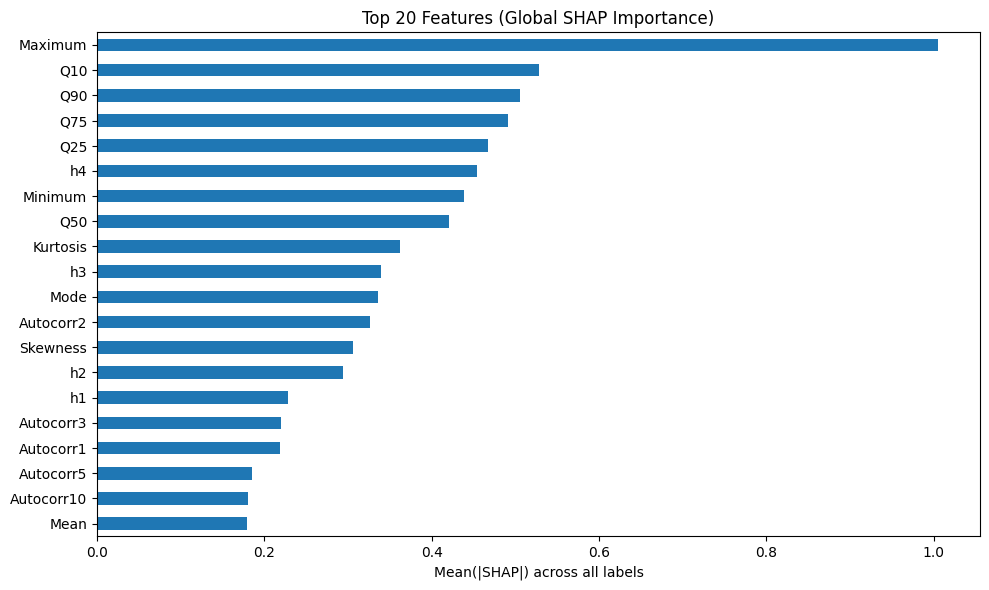

,oestrus,lameness,mastitis,other_disease,mean_global
Maximum,1.099017,0.711758,1.303032,0.907416,1.005306
Q10,0.428168,0.332831,0.787680,0.563107,0.527947
Q90,0.576586,0.387418,0.471660,0.585589,0.505313
Q75,0.565136,0.365205,0.707533,0.325475,0.490837
Q25,0.433503,0.352682,0.755300,0.329212,0.467674
h4,0.265991,0.357288,0.870584,0.322020,0.453971
Minimum,0.398984,0.417439,0.290657,0.649401,0.439120
Q50,0.340746,0.365194,0.558244,0.420449,0.421158
Kurtosis,0.360223,0.543616,0.216830,0.329041,0.362427
h3,0.168884,0.298642,0.556522,0.331914,0.338991


In [ ]:
import shap
import numpy as np

# Stockage des SHAP moyens pour chaque feature par label
shap_matrix = pd.DataFrame(index=X_test.columns)

# Boucle sur chaque label
for i, target in enumerate(label):
    print(f"Traitement de la condition: {target}")

    single_model = multi_model.estimators_[i]
    explainer = shap.Explainer(single_model)
    shap_values = explainer(X_test)

    mean_shap = np.abs(shap_values.values).mean(axis=0)

    # Ajouter les valeurs dans la matrice
    shap_matrix[target] = mean_shap

# Moyenne globale des SHAP values par feature
shap_matrix['mean_global'] = shap_matrix.mean(axis=1)

# Tri des features par importance globale
shap_ranked = shap_matrix.sort_values('mean_global', ascending=False)

# Affichage du top 20
top_features = shap_ranked.head(20)

# Visualisation
plt.figure(figsize=(10, 6))
top_features['mean_global'].plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Features (Global SHAP Importance)")
plt.xlabel("Mean(|SHAP|) across all labels")
plt.tight_layout()
plt.show()

display(top_features)


## Étape 3 : Sélectionner les features importantes with grid search to identify the threshold

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier

import numpy as np
import pandas as pd

# Train-test split (refait pour clarté)
X = final_df[feature_cols]
y = final_df[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Étape 1: Entraîner le modèle initial pour obtenir les SHAP values
base_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, y_train)

# Calcul des SHAP moyens globaux
shap_matrix = pd.DataFrame(index=X_test.columns)

for i, target in enumerate(label):
    explainer = shap.Explainer(multi_model.estimators_[i])
    shap_values = explainer(X_test)
    mean_shap = np.abs(shap_values.values).mean(axis=0)
    shap_matrix[target] = mean_shap

shap_matrix['mean_global'] = shap_matrix.mean(axis=1)

# Étape 2: Essai de plusieurs seuils pour la sélection de features
thresholds = np.arange(0.05, 0.3, 0.02)
# de 0.01 à 0.1 par pas de 0.01
results = []

for threshold in thresholds:
    selected_features = shap_matrix[shap_matrix['mean_global'] >= threshold].index.tolist()

    if not selected_features:
        print(f"🔴 Seuil {threshold}: aucune feature sélectionnée.")
        continue

    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]

    model_sel = MultiOutputClassifier(xgb.XGBClassifier(eval_metric='logloss'))
    model_sel.fit(X_train_sel, y_train)

    y_pred = model_sel.predict(X_test_sel)

    # Évaluation multilabel
    f1 = np.mean([f1_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y.shape[1])])
    precision = np.mean([precision_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y.shape[1])])
    recall = np.mean([recall_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y.shape[1])])

    # Gestion AUC (nécessite predict_proba et au moins deux classes présentes)
    try:
        y_prob = np.column_stack([model_sel.estimators_[i].predict_proba(X_test_sel)[:, 1] for i in range(y.shape[1])])
        auc = np.mean([roc_auc_score(y_test.iloc[:, i], y_prob[:, i]) for i in range(y.shape[1])])
    except Exception as e:
        auc = np.nan

    print(f"✅ Seuil {threshold:.3f} | {len(selected_features)} features | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | AUC: {auc:.4f}")

    results.append({
        'threshold': threshold,
        'num_features': len(selected_features),
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall,
        'roc_auc_macro': auc
    })

# Résumé
results_df = pd.DataFrame(results)
display(results_df.sort_values(by='f1_macro', ascending=False))

c:\Users\ayagr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:57:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayagr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:57:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayagr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:57:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayagr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:57:10] WARNING: C:\actio

✅ Seuil 0.050 | 32 features | F1: 0.8952 | Precision: 0.9667 | Recall: 0.8341 | AUC: 0.9967
✅ Seuil 0.070 | 31 features | F1: 0.8911 | Precision: 0.9555 | Recall: 0.8361 | AUC: 0.9972
✅ Seuil 0.090 | 31 features | F1: 0.8911 | Precision: 0.9555 | Recall: 0.8361 | AUC: 0.9972
✅ Seuil 0.110 | 30 features | F1: 0.8955 | Precision: 0.9587 | Recall: 0.8409 | AUC: 0.9983
✅ Seuil 0.130 | 27 features | F1: 0.8986 | Precision: 0.9516 | Recall: 0.8521 | AUC: 0.9983
✅ Seuil 0.150 | 23 features | F1: 0.9023 | Precision: 0.9635 | Recall: 0.8491 | AUC: 0.9990
✅ Seuil 0.170 | 22 features | F1: 0.8872 | Precision: 0.9520 | Recall: 0.8329 | AUC: 0.9990
✅ Seuil 0.190 | 17 features | F1: 0.9068 | Precision: 0.9586 | Recall: 0.8612 | AUC: 0.9986
✅ Seuil 0.210 | 17 features | F1: 0.9068 | Precision: 0.9586 | Recall: 0.8612 | AUC: 0.9986
✅ Seuil 0.230 | 14 features | F1: 0.9106 | Precision: 0.9666 | Recall: 0.8621 | AUC: 0.9981
✅ Seuil 0.250 | 14 features | F1: 0.9106 | Precision: 0.9666 | Recall: 0.8621 | 

,threshold,num_features,f1_macro,precision_macro,recall_macro,roc_auc_macro
12,0.29,14,0.910610,0.966612,0.862123,0.998080
9,0.23,14,0.910610,0.966612,0.862123,0.998080
10,0.25,14,0.910610,0.966612,0.862123,0.998080
11,0.27,14,0.910610,0.966612,0.862123,0.998080
7,0.19,17,0.906835,0.958574,0.861214,0.998559
8,0.21,17,0.906835,0.958574,0.861214,0.998559
5,0.15,23,0.902314,0.963512,0.849105,0.998962
4,0.13,27,0.898615,0.951577,0.852054,0.998324
3,0.11,30,0.895467,0.958748,0.840900,0.998349
0,0.05,32,0.895215,0.966659,0.834089,0.996717


### Optimal :Seuil 0.15 | 24 features | F1: 0.898374 | Precision: 0.958301 | Recall: 0.846804 | AUC: 0.998558


In [ ]:
threshold = 0.15
selected_features = shap_matrix[shap_matrix['mean_global'] >= threshold].index.tolist()

print(f"🎯 Seuil choisi = {threshold}")
print(f"✅ {len(selected_features)} features sélectionnées :\n{selected_features}")

🎯 Seuil choisi = 0.15
✅ 23 features sélectionnées :
['Minimum', 'Maximum', 'Mean', 'RMS', 'Mode', 'Q10', 'Q90', 'Q25', 'Q50', 'Q75', 'Skewness', 'Kurtosis', 'Autocorr1', 'Autocorr2', 'Autocorr3', 'Autocorr4', 'Autocorr5', 'Autocorr6', 'Autocorr10', 'h1', 'h2', 'h3', 'h4']


## Étape 4 : Refaire un modèle avec seulement les features sélectionnées (round 2)

In [ ]:
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

final_model = MultiOutputClassifier(xgb.XGBClassifier(eval_metric='logloss'))
final_model.fit(X_train_sel, y_train)

# Prédictions
y_pred = final_model.predict(X_test_sel)

# Évaluation
f1 = np.mean([f1_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y.shape[1])])
precision = np.mean([precision_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y.shape[1])])
recall = np.mean([recall_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y.shape[1])])

# AUC
try:
    y_prob = np.column_stack([final_model.estimators_[i].predict_proba(X_test_sel)[:, 1] for i in range(y.shape[1])])
    auc = np.mean([roc_auc_score(y_test.iloc[:, i], y_prob[:, i]) for i in range(y.shape[1])])
except:
    auc = np.nan

print("\n📊 Performances finales avec le seuil sélectionné :")
print(f"F1 score macro     : {f1:.4f}")
print(f"Precision macro    : {precision:.4f}")
print(f"Recall macro       : {recall:.4f}")
print(f"ROC AUC macro      : {auc:.4f}")


📊 Performances finales avec le seuil sélectionné :
F1 score macro     : 0.9023
Precision macro    : 0.9635
Recall macro       : 0.8491
ROC AUC macro      : 0.9990


# Data classification

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import (
#     accuracy_score, f1_score, recall_score, precision_score,
#     confusion_matrix, classification_report
# )
# import numpy as np
# import pandas as pd

# # 1. Créer la colonne target (single-label)
# def get_target_label(row):
#     for label in ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease']:
#         if row[label] == 1:
#             return label
#     return 'ok'

# final_df['target'] = final_df.apply(get_target_label, axis=1)

# # 2. Sélection des features
# X = final_df[selected_features]
# y = final_df['target']

# # 3. Split des données : 10% validation, 90% reste
# X_remain, X_val, y_remain, y_val = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)

# # 4. Split du reste en 70% train et 20% test (2/9 ≈ 0.222)
# X_train, X_test, y_train, y_test = train_test_split(X_remain, y_remain, test_size=2/9, random_state=42, stratify=y_remain)

# # 5. Entraînement du modèle Random Forest
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, y_train)

# # 6. Prédiction sur le jeu de test
# y_pred = clf.predict(X_test)

# # 7. Rapport de classification
# print("\n📋 Classification Report:")
# print(classification_report(y_test, y_pred))

# # 8. Calcul manuel des métriques
# accuracy = accuracy_score(y_test, y_pred)
# f1_macro = f1_score(y_test, y_pred, average='macro')
# precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
# recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)

# # 9. Spécificité (macro)
# labels = clf.classes_
# cm = confusion_matrix(y_test, y_pred, labels=labels)

# specificity_per_class = []
# for i, label in enumerate(labels):
#     TP = cm[i, i]
#     FN = cm[i, :].sum() - TP
#     FP = cm[:, i].sum() - TP
#     TN = cm.sum() - (TP + FP + FN)
#     specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
#     specificity_per_class.append(specificity)

# specificity_macro = np.mean(specificity_per_class)

# # 10. Résumé
# print(f"\n📊 Evaluation Metrics:")
# print(f"Accuracy           : {accuracy:.4f}")
# print(f"F1 Score (Macro)   : {f1_macro:.4f}")
# print(f"Precision (Macro)  : {precision_macro:.4f}")
# print(f"Recall/Sensitivity : {recall_macro:.4f}")
# print(f"Specificity (Macro): {specificity_macro:.4f}")


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import (
#     accuracy_score, f1_score, recall_score, precision_score,
#     confusion_matrix, classification_report
# )
# import numpy as np
# import pandas as pd

# # 1. Créer la colonne target (single-label)
# def get_target_label(row):
#     for label in ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease']:
#         if row[label] == 1:
#             return label
#     return 'ok'

# final_df['target'] = final_df.apply(get_target_label, axis=1)

# # 2. Sélection des features
# X = final_df[selected_features]
# y = final_df['target']

# # 3. Split des données : 10% validation, 90% reste
# X_remain, X_val, y_remain, y_val = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(X_remain, y_remain, test_size=2/9, random_state=42, stratify=y_remain)

# # Liste des n_estimators à tester
# n_estimators_list = [10, 50, 100, 150, 200]

# # Stockage des résultats
# results = []

# for n in n_estimators_list:
#     print(f"\n🔁 Training with n_estimators = {n}")

#     # 4. Entraînement
#     clf = RandomForestClassifier(n_estimators=n, random_state=42)
#     clf.fit(X_train, y_train)

#     # 5. Prédiction
#     y_pred = clf.predict(X_test)

#     # 6. Métriques de base
#     accuracy = accuracy_score(y_test, y_pred)
#     f1_macro = f1_score(y_test, y_pred, average='macro')
#     precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
#     recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)

#     # 7. Spécificité macro
#     labels = clf.classes_
#     cm = confusion_matrix(y_test, y_pred, labels=labels)
#     specificity_per_class = []
#     for i, label in enumerate(labels):
#         TP = cm[i, i]
#         FN = cm[i, :].sum() - TP
#         FP = cm[:, i].sum() - TP
#         TN = cm.sum() - (TP + FP + FN)
#         specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
#         specificity_per_class.append(specificity)
#     specificity_macro = np.mean(specificity_per_class)

#     # 8. Stocker les résultats
#     results.append({
#         'n_estimators': n,
#         'accuracy': accuracy,
#         'f1_macro': f1_macro,
#         'precision_macro': precision_macro,
#         'recall_macro': recall_macro,
#         'specificity_macro': specificity_macro
#     })

# # 9. Résumé des résultats
# df_results = pd.DataFrame(results)
# print("\n📈 Résultats comparatifs :")
# print(df_results)


###  Create target column


In [ ]:
# Create the 'target' column based on multiple binary columns
def get_target_label(row):
    for label in ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease']:
        if row[label] == 1:
            return label
    return 'ok'

final_df['target'] = final_df.apply(get_target_label, axis=1)


### Split 10% validation and 90% remaining data

In [ ]:
from sklearn.model_selection import train_test_split

# Split data: 10% for validation, 90% remaining
df_remain, df_val = train_test_split(
    final_df, test_size=0.10, random_state=42, stratify=final_df['target']
)


### Save validation and remaining data to CSV

In [ ]:
# Save to CSV files
df_val.to_csv("validation_10_percent.csv", index=False)
df_remain.to_csv("train_test_90_percent.csv", index=False)


### Split 90% into 80% training and 20% testing

In [ ]:
# Select features and target from remaining 90%
X_remain = df_remain[selected_features]
y_remain = df_remain['target']

# Split into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_remain, y_remain, test_size=0.20, random_state=42, stratify=y_remain
)


In [ ]:

from sklearn.model_selection import train_test_split, GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("✅ Best parameters found:", grid_search.best_params_)

best_clf = grid_search.best_estimator_


Fitting 5 folds for each of 36 candidates, totalling 180 fits
✅ Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


### Train Random Forest model

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# # Train the classifier
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, y_train)


In [ ]:
best_clf.fit(X_train, y_train)
y_predict = best_clf.predict(X_test)


### Make predictions

In [ ]:
# # Predict on the test set
# y_predict = clf.predict(X_test)


### Print classification report

In [ ]:
# from sklearn.metrics import classification_report

# # Display classification report
# print("\n📋 Classification Report:")
# print(classification_report(y_test, y_predict))


In [ ]:
print("\n📋 Classification Report:")
print(classification_report(y_test, y_predict))



📋 Classification Report:
               precision    recall  f1-score   support

     lameness       0.98      0.73      0.83       315
     mastitis       1.00      0.63      0.77        57
      oestrus       0.95      0.41      0.57       103
           ok       0.97      1.00      0.98      6527
other_disease       0.99      0.62      0.76       154

     accuracy                           0.97      7156
    macro avg       0.98      0.68      0.78      7156
 weighted avg       0.97      0.97      0.96      7156



### summary metrics

In [ ]:
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# # Compute metrics
# accuracy = accuracy_score(y_test, y_predict)
# f1_macro = f1_score(y_test, y_predict, average='macro')
# precision_macro = precision_score(y_test, y_predict, average='macro', zero_division=0)
# recall_macro = recall_score(y_test, y_predict, average='macro', zero_division=0)


In [ ]:
# from sklearn.metrics import confusion_matrix
# import numpy as np

# labels = clf.classes_
# cm = confusion_matrix(y_test, y_predict, labels=labels)

# specificity_per_class = []
# for i, label in enumerate(labels):
#     TP = cm[i, i]
#     FN = cm[i, :].sum() - TP
#     FP = cm[:, i].sum() - TP
#     TN = cm.sum() - (TP + FP + FN)
#     specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
#     specificity_per_class.append(specificity)

# specificity_macro = np.mean(specificity_per_class)
# # Print final metrics summary
# print(f"\n📊 Evaluation Metrics:")
# print(f"Accuracy           : {accuracy:.4f}")
# print(f"F1 Score (Macro)   : {f1_macro:.4f}")
# print(f"Precision (Macro)  : {precision_macro:.4f}")
# print(f"Recall/Sensitivity : {recall_macro:.4f}")
# print(f"Specificity (Macro): {specificity_macro:.4f}")


In [ ]:
from sklearn.metrics import (
    accuracy_score,)
accuracy = accuracy_score(y_test, y_predict)
f1_macro = f1_score(y_test, y_predict, average='macro')
precision_macro = precision_score(y_test, y_predict, average='macro', zero_division=0)
recall_macro = recall_score(y_test, y_predict, average='macro', zero_division=0)
labels = best_clf.classes_
cm = confusion_matrix(y_test, y_predict, labels=labels)

specificity_per_class = []
for i, label in enumerate(labels):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificity_per_class.append(specificity)

specificity_macro = np.mean(specificity_per_class)
print(f"\n📊 Evaluation Metrics:")
print(f"Accuracy           : {accuracy:.4f}")
print(f"F1 Score (Macro)   : {f1_macro:.4f}")
print(f"Precision (Macro)  : {precision_macro:.4f}")
print(f"Recall/Sensitivity : {recall_macro:.4f}")
print(f"Specificity (Macro): {specificity_macro:.4f}")



📊 Evaluation Metrics:
Accuracy           : 0.9674
F1 Score (Macro)   : 0.7845
Precision (Macro)  : 0.9779
Recall/Sensitivity : 0.6765
Specificity (Macro): 0.9282


In [ ]:
# from sklearn.metrics import (
#     accuracy_score, f1_score, recall_score, precision_score,
#     confusion_matrix
# )
# import numpy as np
# import pandas as pd

# # Predict on test set
# y_pred = clf.predict(X_test)

# # Accuracy
# accuracy = accuracy_score(y_test, y_pred)

# # Macro-averaged F1, Precision, Recall (Sensitivity)
# f1_macro = f1_score(y_test, y_pred, average='macro')
# precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
# recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)

# # Confusion Matrix
# labels = clf.classes_
# cm = confusion_matrix(y_test, y_pred, labels=labels)

# # Specificity per class: TN / (TN + FP)
# # For multiclass, specificity is computed per class using One-vs-Rest strategy
# specificity_per_class = []
# for i, label in enumerate(labels):
#     TP = cm[i, i]
#     FN = cm[i, :].sum() - TP
#     FP = cm[:, i].sum() - TP
#     TN = cm.sum() - (TP + FP + FN)
#     specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
#     specificity_per_class.append(specificity)

# # Mean Specificity
# specificity_macro = np.mean(specificity_per_class)

# # Results Summary
# print(f"\n📊 Evaluation Metrics:")
# print(f"Accuracy           : {accuracy:.4f}")
# print(f"F1 Score (Macro)   : {f1_macro:.4f}")
# print(f"Precision (Macro)  : {precision_macro:.4f}")
# print(f"Recall/Sensitivity : {recall_macro:.4f}")
# print(f"Specificity (Macro): {specificity_macro:.4f}")


# Data augmentation


# SMOTE

In [ ]:
!pip install imbalanced-learn



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
print(df['OK'].value_counts())


OK
1    36259
0     3495
Name: count, dtype: int64


In [ ]:
print(df.isnull().sum())


cow                0
start_time         0
end_time           0
duration_hours     0
Minimum            0
Maximum            0
Mean               0
RMS                0
STD                0
MeanSTD6h         29
STDMean6h         29
STDSD              0
RMSSD              0
Mode               0
Q10                0
Q90                0
Q25                0
Q50                0
Q75                0
Skewness           0
Kurtosis           0
Autocorr1          0
Autocorr2          0
Autocorr3          0
Autocorr4          0
Autocorr5          0
Autocorr6          0
Autocorr7          0
Autocorr8          0
Autocorr9          0
Autocorr10         0
Autocorr11         0
h1                 0
h2                 0
h3                 0
h4                 0
oestrus            0
calving            0
lameness           0
mastitis           0
other_disease      0
OK                 0
target             0
dtype: int64


In [ ]:
# import pandas as pd
# from imblearn.over_sampling import SMOTE
# from collections import Counter

# # Exemple dataframe df déjà nettoyé et préparé (dates converties en timestamp, etc.)

# # Liste des colonnes cibles à traiter
# target_columns = ['OK', 'oestrus', 'lameness', 'mastitis', 'other_disease']

# # Sélectionne les colonnes numériques des features (à adapter)
# X = df.drop(columns=target_columns)
# X = X.select_dtypes(include=['int64', 'float64'])

# for target in target_columns:
#     print(f"\nTraitement de la cible : {target}")
#     y = df[target]

#     print("Avant SMOTE :", Counter(y))

#     sm = SMOTE(random_state=42)
#     X_res, y_res = sm.fit_resample(X, y)

#     print("Après SMOTE :", Counter(y_res))

#     # Convert to DataFrames
#     X_res_df = pd.DataFrame(X_res, columns=X.columns)
#     y_res_df = pd.Series(y_res, name=target)

#     # Combine
#     full_resampled_df = pd.concat([X_res_df, y_res_df], axis=1)

#     # Filter only the new rows (those that weren't in the original data)
#     n_original = len(df)
#     new_samples_df = full_resampled_df.iloc[n_original:]

#     # Save to CSV
#     csv_name = f"synthetic_samples_{target}.csv"
#     new_samples_df.to_csv(csv_name, index=False)
#     print(f"Synthetic samples for {target} saved to {csv_name}")


# GAN

In [ ]:
!pip install sdv


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# import pandas as pd
# from collections import Counter
# from sdv.single_table import CTGANSynthesizer
# from sdv.metadata import SingleTableMetadata


# minor_labels = [ 'oestrus', 'lameness', 'mastitis', 'other_disease']

# feature_cols = ['duration_hours', 'Minimum', 'Maximum', 'Mean', 'RMS', 'STD', 'MeanSTD6h',
#                 'STDMean6h', 'STDSD', 'RMSSD', 'Mode', 'Q10', 'Q90', 'Q25', 'Q50', 'Q75',
#                 'Skewness', 'Kurtosis', 'Autocorr1', 'Autocorr2', 'Autocorr3', 'Autocorr4',
#                 'Autocorr5', 'Autocorr6', 'Autocorr7', 'Autocorr8', 'Autocorr9', 'Autocorr10',
#                 'Autocorr11', 'h1', 'h2', 'h3', 'h4']

# # 🧾 Afficher les counts AVANT augmentation
# print("✅ Comptage des labels avant l’augmentation :\n")
# for label in minor_labels + ['OK']:
#     count_1 = final_df[label].sum()
#     count_0 = len(final_df) - count_1
#     print(f"{label:15s} : 1s = {int(count_1):6d} | 0s = {int(count_0):6d}")

# synthetic_dfs = []

# for label in minor_labels:
#     print(f"\n🔄 Génération de données pour : {label}")

#     # Étape 1 : Extraire les exemples avec label = 1
#     minority_df = final_df[final_df[label] == 1]
#     minority_df_features = minority_df[feature_cols]

#     # Étape 2 : Définir les métadonnées
#     metadata = SingleTableMetadata()
#     metadata.detect_from_dataframe(minority_df_features)

#     # Étape 3 : Entraîner un CTGAN sur les données minoritaires
#     synthesizer = CTGANSynthesizer(metadata)
#     synthesizer.fit(minority_df_features)

#     # Étape 4 : Générer des données synthétiques
#     synthetic_data = synthesizer.sample(1000)  # à ajuster selon les besoins

#     # Étape 5 : Ajouter les labels synthétiques
#     for col in minor_labels + ['OK']:
#         synthetic_data[col] = 1 if col == label else 0

#     print("📊 Comptage des labels générés :")
#     for col in minor_labels + ['OK']:
#         count_1 = (synthetic_data[col] == 1).sum()
#         count_0 = (synthetic_data[col] == 0).sum()
#         print(f"Label '{col:15s}' - 1s: {count_1:4d} | 0s: {count_0:4d}")

#     synthetic_dfs.append(synthetic_data)

# # Étape 5 : Fusionner les données
# synthetic_all = pd.concat(synthetic_dfs, ignore_index=True)
# augmented_df = pd.concat([final_df, synthetic_all], ignore_index=True)

# # 🧾 Afficher les counts APRÈS augmentation
# print("\n✅ Comptage des labels APRÈS l’augmentation :\n")
# print("\n✅ Comptage des labels APRÈS l’augmentation :\n")
# for label in minor_labels + ['OK']:
#     count_1 = augmented_df[label].sum()
#     count_0 = len(augmented_df) - count_1
#     print(f"{label:15s} : 1s = {int(count_1):6d} | 0s = {int(count_0):6d}")
